In [46]:
import os;
import sys;
sys.path.append("venv")

In [47]:
import pandas as pd
df = pd.read_parquet('../normalised_data/WSE.parquet', engine='pyarrow')
df.count()

timestamp        645585
symbol           645585
bid_price        515386
bid_size         515386
ask_price        515386
ask_size         515386
market_period    515386
trade_price      130199
trade_volume     130199
type             645585
dtype: int64

In [48]:
pd.read_parquet('../symbology_data/NASDAQ.parquet', engine='pyarrow')

,symbol
0,WMPN
1,WLYB
2,SBR
3,ATHE
4,HLTH
...,...
9375,SDIV
9376,SNOA
9377,BN
9378,NTRSO


In [1]:
from regionConfig.WSE import WSE
from regionConfig.NASDAQ import NASDAQ
# Spread sizes

import aggregator
import filters


class SpreadByTickSizeAggregate(aggregator.Aggregate):
    def __init__(self, region, symbol):
        self.last_bid = 0.0
        self.last_ask = 0.0
        self.region = region
        self.tick_series = []

    def on_quote(self, quote):
        self.spread = quote.ask_price - quote.bid_price

    def on_trade(self, trade):
        tick_size = self.region.get_tick_size(trade.trade_price, trade.symbol)
        if tick_size != 0 and self.spread > 0:
            self.tick_series.append(self.spread / tick_size)

    def compute_slice(self, slice):
        if len(self.tick_series) == 0:
            return 0

        value = sum(self.tick_series) / len(self.tick_series)
        return value



# agg = aggregator.Aggregator( WSE(),"20240122")
# agg.registerAggregate(SpreadByTickSizeAggregate)
# aggs_wse = agg.run()

agg = aggregator.Aggregator(NASDAQ(),"20240122",filters.SymbolFilter('AAPL') )
agg.registerAggregate(SpreadByTickSizeAggregate)
aggs_nasdaq = agg.run()
aggs_nasdaq

,symbol,slice,aggregate,value
0,AAPL,09:00:00,SpreadByTickSize,0
1,AAPL,09:05:00,SpreadByTickSize,0
2,AAPL,09:10:00,SpreadByTickSize,0
3,AAPL,09:15:00,SpreadByTickSize,0
4,AAPL,09:20:00,SpreadByTickSize,0
...,...,...,...,...
78,AAPL,15:30:00,SpreadByTickSize,0
79,AAPL,15:35:00,SpreadByTickSize,0
80,AAPL,15:40:00,SpreadByTickSize,0
81,AAPL,15:45:00,SpreadByTickSize,0


In [3]:
import datetime
eod_slice = datetime.time(15,50,00)
aggs_nasdaq.query("slice == @eod_slice")


,symbol,slice,aggregate,value
82,WMPN,15:50:00,SpreadByTickSize,0
165,WLYB,15:50:00,SpreadByTickSize,0
248,SBR,15:50:00,SpreadByTickSize,0
331,ATHE,15:50:00,SpreadByTickSize,0
414,HLTH,15:50:00,SpreadByTickSize,0
...,...,...,...,...
778207,SDIV,15:50:00,SpreadByTickSize,0
778290,SNOA,15:50:00,SpreadByTickSize,0
778373,BN,15:50:00,SpreadByTickSize,0
778456,NTRSO,15:50:00,SpreadByTickSize,0


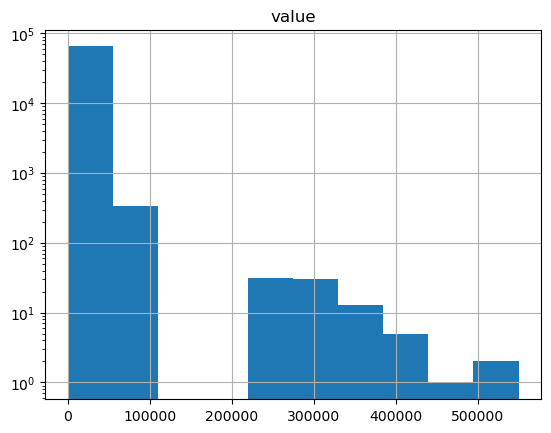

In [42]:

ax = aggs.hist(column='value', bins=10, log=True)

In [2]:
from regionConfig.WSE import WSE
# Spread sizes

import aggregator
import filters

class TradeCountAggregate(aggregator.Aggregate):
    def __init__(self, region, symbol):
        self.trade_count = 0

    def on_quote(self, quote):
        pass

    def on_trade(self, trade):
        self.trade_count+=1

    def compute_slice(self, slice):
        val = self.trade_count
        self.trade_count = 0 
        return val
    
class QuoteCountAggregate(aggregator.Aggregate):
    def __init__(self, region, symbol):
        self.quote_count = 0

    def on_quote(self, quote):
        self.quote_count+=1

    def on_trade(self, trade):
        pass

    def compute_slice(self, slice):
        val = self.quote_count
        self.quote_count = 0 
        return val

agg = aggregator.Aggregator(WSE(),"20240122" )
agg.registerAggregate(TradeCountAggregate)
agg.registerAggregate(QuoteCountAggregate)
trade_count_aggs = agg.run()
trade_count_aggs

,symbol,slice,aggregate,value
0,YAN,09:00:00,TradeCount,0
1,YAN,09:05:00,TradeCount,0
2,YAN,09:10:00,TradeCount,0
3,YAN,09:15:00,TradeCount,0
4,YAN,09:20:00,TradeCount,0
...,...,...,...,...
130637,ZAP,15:30:00,QuoteCount,0
130638,ZAP,15:35:00,QuoteCount,1
130639,ZAP,15:40:00,QuoteCount,2
130640,ZAP,15:45:00,QuoteCount,1


In [3]:
import pandas as pd
import datetime
first_slice_time = datetime.time(9,0,0)
trade_counts = trade_count_aggs.query('aggregate == "TradeCount"').groupby('symbol')["value"].sum()
quote_counts = trade_count_aggs.query('aggregate == "QuoteCount"').groupby('symbol')["value"].sum()
pd.DataFrame(trade_counts)

pd.merge(trade_counts, quote_counts, on='symbol', how='outer').query('value_x == 0')


,value_x,value_y
symbol,,
7FT,0,2
AAS,0,1
ABK,0,2
ADS,0,2198
AFC,0,1
...,...,...
XBS,0,3
YAN,0,10
YBS,0,2


In [9]:
import datetime
time = datetime.time(15,50,00)
aggs.query('slice == @time and value == 0')
#aggs.query('symbol == "PKO"')

,symbol,slice,aggregate,value


In [5]:
import sys
import aggregator
import filters


class volumeAggregate(aggregator.Aggregate):
    def __init__(self, region, symbol):
        self.volume = 0

    def on_quote(self, quote):
        pass

    def on_trade(self, trade):
        self.volume += trade.trade_volume

    def compute_slice(self, slice):
        ret = self.volume
        self.volume = 0
        return ret


agg = aggregator.Aggregator(WSE(), "20240122", filters.SymbolFilter('PKO'))
agg.registerAggregate(volumeAggregate)
agg.run()

,symbol,slice,aggregate,value
0,PKO,09:00:00,volume,0.0
1,PKO,09:05:00,volume,100989.0
2,PKO,09:10:00,volume,16314.0
3,PKO,09:15:00,volume,159776.0
4,PKO,09:20:00,volume,113276.0
...,...,...,...,...
78,PKO,15:30:00,volume,9423.0
79,PKO,15:35:00,volume,17653.0
80,PKO,15:40:00,volume,16664.0
81,PKO,15:45:00,volume,23848.0
